# Blog Post 3: Model Pipeline, Individual Nuclei Segmentation, and Future Work

In this post, we'll go over the following key points:

1. comment on why we're not doing modality separation
1. overview of our current pipeline
    1. discuss our hand designed features
    1. discuss our model choices
    1. discuss our post processing and individual nucleus segmentation
1. discuss our plan moving forward

## about those modalities

In our last post, we did intensive EDA on the different modalities in our training set.  While it ended up being very valuable work for understanding our data, we decided to abandon the separation of modalities here on out.

See [this discussion post](https://www.kaggle.com/c/data-science-bowl-2018/discussion/47640) for some example images of the different training modalities.  In the same post, other Kagglers found that there are **different** modalities in the test set!  And the data curators revealed that there will be even more **different** modalities in the Stage 2 test set!!  As a result, we felt that any model depending on modality metadata would be insufficient for this task, so we are now focusing our efforts on a model that generalizes well for all modalities.

One detail that we have to be careful of, however, is that some modalities have dark nuclei on white backgrounds, while some have bright nuclei on dark backgrounds.  In order to present our model with appropriate training data, we invert images found on white backgrounds.  Currently, we simply take the mean of an image, and if it's greater than a constant threshold, we invert.

## current pipeline

The pipeline has a few steps:

* read in data
* preprocess and resize to the same shape (we're using (256 x 256))
* expand each pixel's features from RGB to a set of hand-designed features
* train a Regressor with Mini Batch SGD on pixel data (flatten all images to make a large corpus on pixels)
* predict the regression output on each pixel in an image, to form a prediction for such an image
* perform a local thresholding using a combination of otsu's binarization and non maximum supression
* perform individual nucleus segmentation
* submit and get $$$

### reading data and preprocessing

In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["text.usetex"] = True
plt.rcParams["figure.dpi"] = 50

import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

In [135]:
from deton8.utils import DataReader
from sklearn.model_selection import train_test_split

training = DataReader("../data/training/")
train_metadata, x_train = training.get()

y_train = np.stack(training.masks)
train_metadata, val_metadata, x_train, x_val, y_train, y_val = train_test_split(train_metadata, x_train, y_train, train_size = 0.8)

/Users/williamlevine/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### basis transformation

The first step in our pipeline relies on transforming the pixels from our original RGB feature space to an expanded space of 9 hand-designed features.  In the following cells, we'll present some examples of our chosen features.  Here's a listing:

1. Red Channel
2. Green Channel
3. Blue Channel
4. pixel's z-score w.r.t image
5. bilateral filter
6. average of RGB Channels after a rescaling between 2% and 98% of the full range
7. average of RGB Channels after a Contrast Limited Adaptive Histogram Equalization
8. average of RGB Channels after a dilation
9. pixel's mean distance from it's 8-connectivity neighbors using the previous 8 features as dimensions

In [584]:
np.savez('../data/style_image.npz', style_image = np.expand_dims(x_train[9], axis = 0))

In [453]:
from deton8.computer_vision import ColorMatcher
cm = ColorMatcher()
x_train_preprocessed = cm.fit_transform(np.expand_dims(x_train[9], axis = 0), x_train)

In [454]:
x_val_preprocessed = cm.fit_transform(np.expand_dims(x_train[9], axis = 0), x_val)

In [467]:
from deton8.analytical import BasisTransformer
transformer = BasisTransformer()
x_train_transformed = transformer.fit_transform(np.array(x_train_preprocessed))

100%|██████████| 536/536 [00:23<00:00, 22.82pair/s]


In [468]:
x_val_transformed = transformer.fit_transform(np.array(x_val_preprocessed))

100%|██████████| 134/134 [00:05<00:00, 25.03pair/s]


In [469]:
img = x_val_transformed[100]

#### z-score

We first take the average of the image channels and then compute a pixel's deviation from the overall mean divided by the overall standard deviation.  Observe some images below.

Text(0.5,1,'z-score')

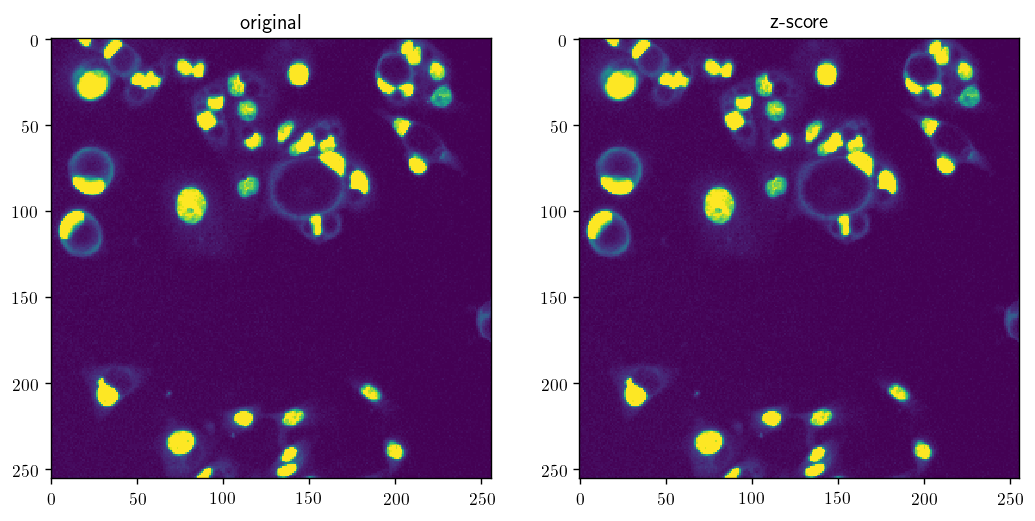

In [481]:
plt.subplot(121)
plt.imshow(img[:, :, 0])
plt.title("original")
plt.subplot(122)
plt.imshow(img[:, :, 3])
plt.title("z-score")

We chose to include this feature as it provides a clear contrast between light pixels which represent nuclei and the background of the image.

#### bilateral filter

A bilateral filter is an edge preserving filter that reduces noise in an image.  We chose to include this filter because it will preserve the edges of our nuclei while smoothing brightness into somewhat darker areas of the nuclei.

Text(0.5,1,'bilateral filter')

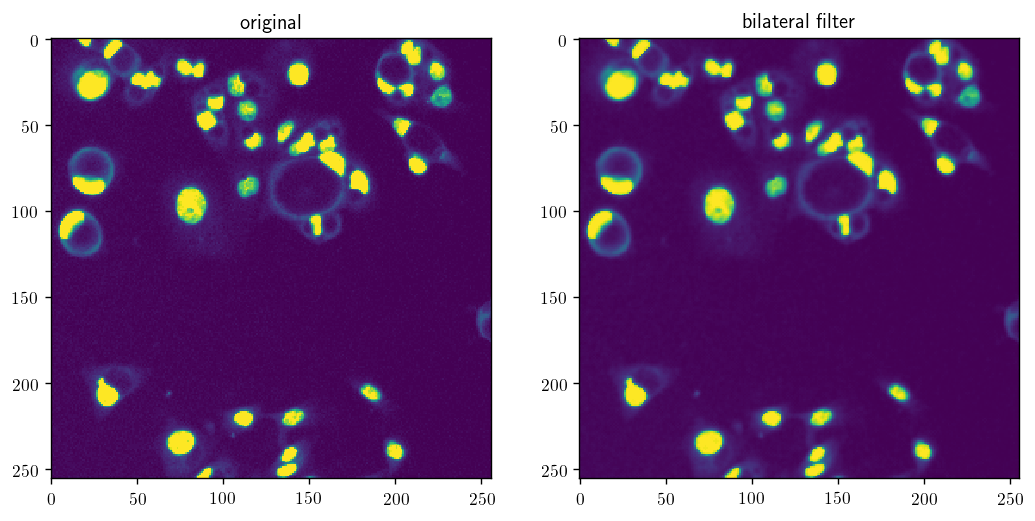

In [482]:
plt.subplot(121)
plt.imshow(img[:, :, 0])
plt.title("original")
plt.subplot(122)
plt.imshow(img[:, :, 4])
plt.title("bilateral filter")

#### rescaling

This feature takes the 2nd and 98th percentile of an image and rescales the values to be in this range.  The effect is an increase of 
contrast, since all values from the 98th to the 100th percentile are set to the maximum value and all values from the 0th to the 2nd percentile are set to the minimum value.  It also stretches the values inside the 2nd to 98th percentile a bit.  As we can see, the effect is quite desirable.  Our true nuclei are amplified, and noise around the nuclei isn't too drastically.

Text(0.5,1,'rescaling')

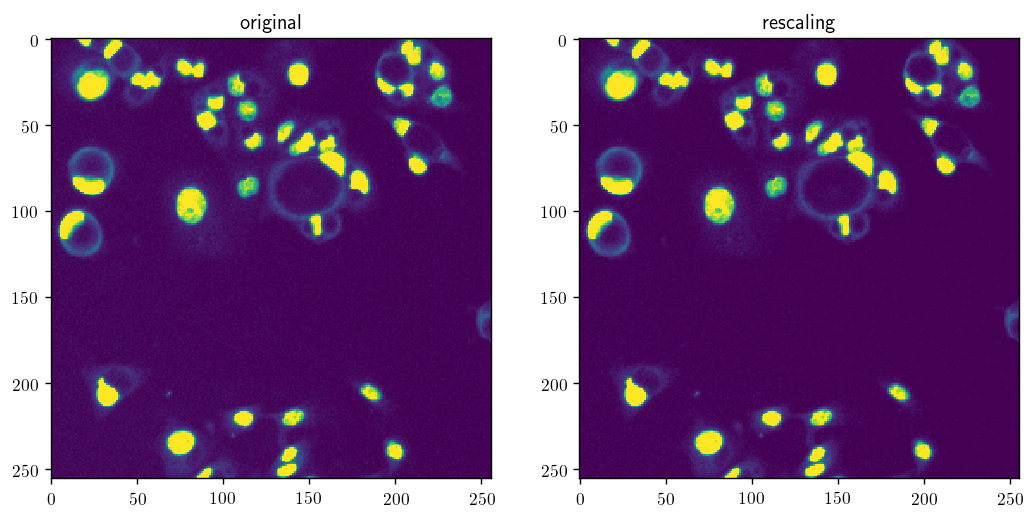

In [483]:
plt.subplot(121)
plt.imshow(img[:, :, 0])
plt.title("original")
plt.subplot(122)
plt.imshow(img[:, :, 5])
plt.title("rescaling")

#### CL AHE

This feature performs a Contrast Limited Adaptive Histogram Equalization, which is quite a mouthful.  Conceptually we can think of this method as performing a sort of local rescaling -- which is quite attractive to us.  We increase the contrast in a local region rather than a global region, which will exclude that large portion of background "zeros".  The "Contrast Limited" portion takes the adaptive (local) histogram and will "clip" bins at a certain threshold, redistributing weight to the other bins equally.  Refer to [this wikipedia article](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization) for more details.

Text(0.5,1,'cl ahe')

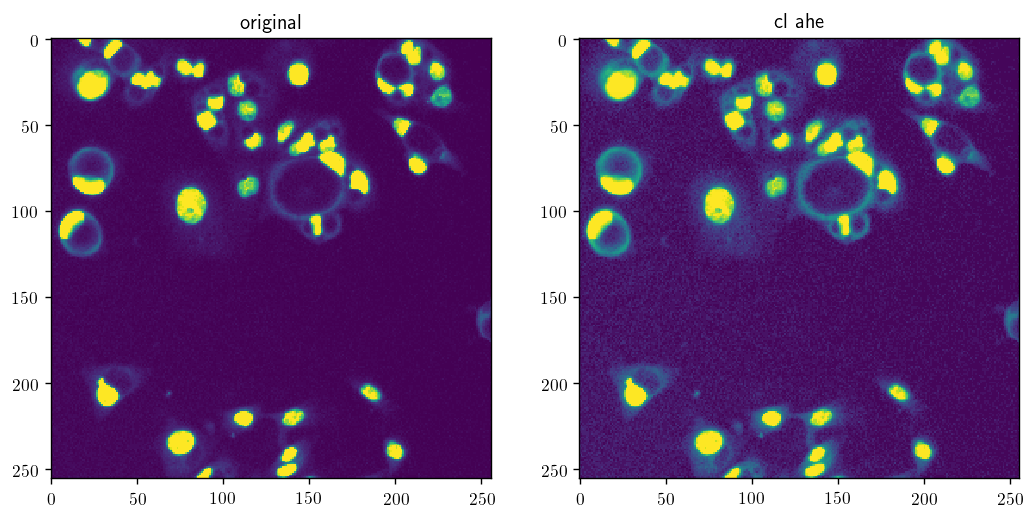

In [484]:
plt.subplot(121)
plt.imshow(img[:, :, 0])
plt.title("original")
plt.subplot(122)
plt.imshow(img[:, :, 6])
plt.title("cl ahe")

#### dilation

This features dialates bright areas in an image.  Here we use a structuring element of a large matrix of ones, but we may experiment with a disk element to dilate more naturally for nuclei.  It seems that we have somewhat of a strange effect on the image below.  However, we like this feature since it provides a region around the nuclei which decays in magnitude as it gets further from the center of a nucleus.

Text(0.5,1,'dilation results')

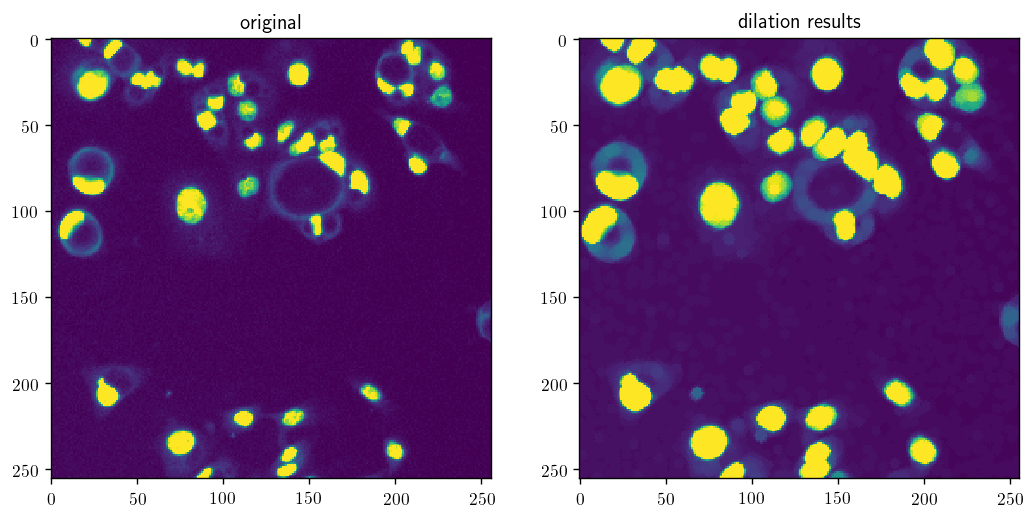

In [485]:
plt.subplot(121)
plt.imshow(img[:, :, 0])
plt.title("original")
plt.subplot(122)
plt.imshow(img[:, :, 7])
plt.title("dilation results")

### Training

We have 670 images in our training set and we resize each image to be 256 x 256.  Since we're simply training our models with our basis transformed pixels, we have 670 * 256 * 256 points at this point in our training task.  Since this is over 43 million data points, we're not going to be able to train this dataset at once, so we'll have to rely on online, or mini-batch learning.  

So, we've restricted ourselves to two regressors from `scikit-learn`, the `SGDRegressor` using an elastic net penalty, and the `PassiveAggressiveRegressor`.  Both regressors support mini-batch learning.

We chose to frame this problem as a regression problem so we predict "probabilities" and then perform the local thresholding to determine how to binarize ourselves.

In [486]:
from deton8.utils import flatten_data

y_dev = y_train

x_dev_flat, y_dev_flat = flatten_data(x_train_transformed, y_dev, skip=1)
x_val_flat, y_val_flat = flatten_data(x_val_transformed, y_val, skip=1)

In [487]:
from deton8.models import MiniBatchRegressor
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor
from tqdm import tqdm_notebook as tqdm

sgd_regressor = MiniBatchRegressor(
    regressor=SGDRegressor(penalty='elasticnet', l1_ratio=0.11),
    batch_size=1000,
    num_iters=50000,
    tqdm=tqdm
)

sgd_regressor.fit(x_dev_flat, y_dev_flat)

HBox(children=(IntProgress(value=0, max=50000), HTML(value='')))

/Users/williamlevine/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [508]:
from sklearn.linear_model import PassiveAggressiveRegressor

pa_regressor = MiniBatchRegressor(
    regressor=PassiveAggressiveRegressor(C = .2),
    batch_size=1000,
    num_iters=1000,
    tqdm=tqdm
)

pa_regressor.fit(x_dev_flat, y_dev_flat)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

/Users/williamlevine/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [531]:
np.savez('../weights/regressor_weights.npz', sgd = sgd_regressor.regressor.coef_, pa = pa_regressor.regressor.coef_)

In [500]:
from deton8.visualization import plot_prediction

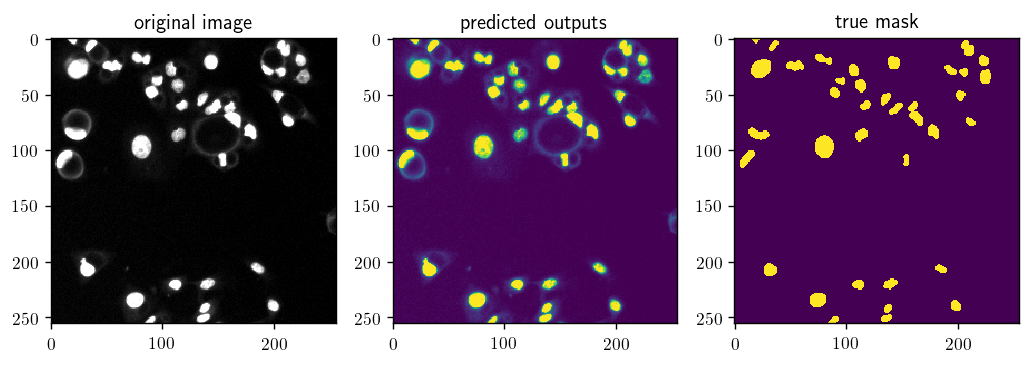

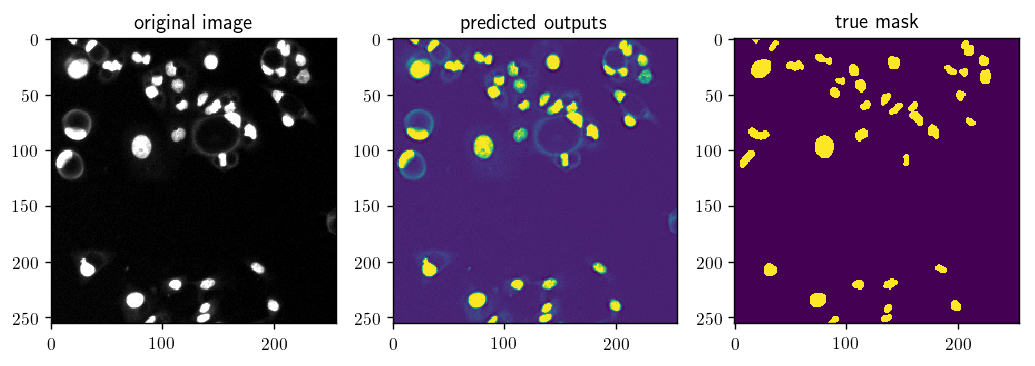

In [509]:
num = 100
plot_prediction(sgd_regressor, x_val_transformed[num], y_val[num])
plot_prediction(pa_regressor, x_val_transformed[num], y_val[num])

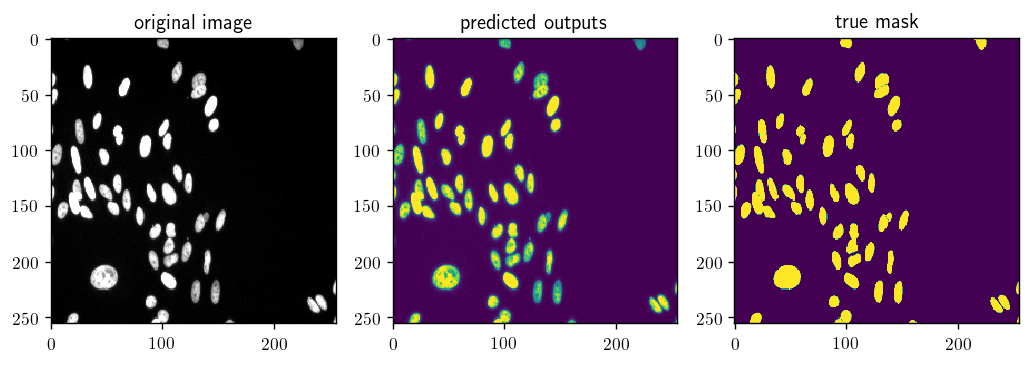

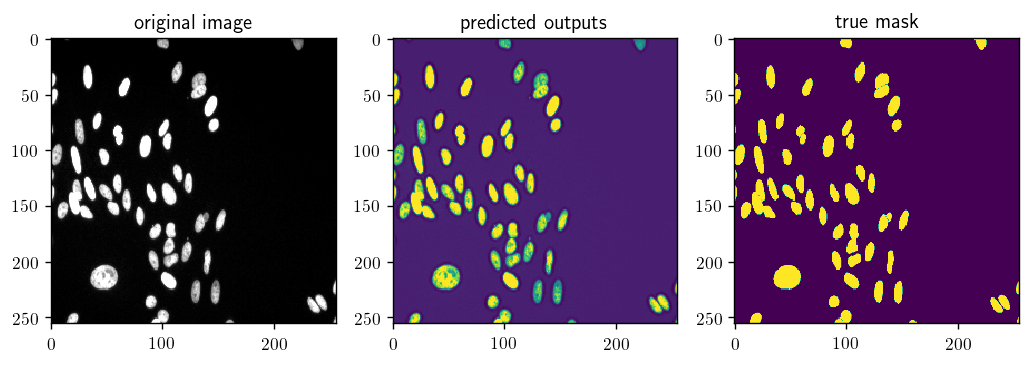

In [510]:
num = 2
plot_prediction(sgd_regressor, x_val_transformed[num], y_val[num])
plot_prediction(pa_regressor, x_val_transformed[num], y_val[num])

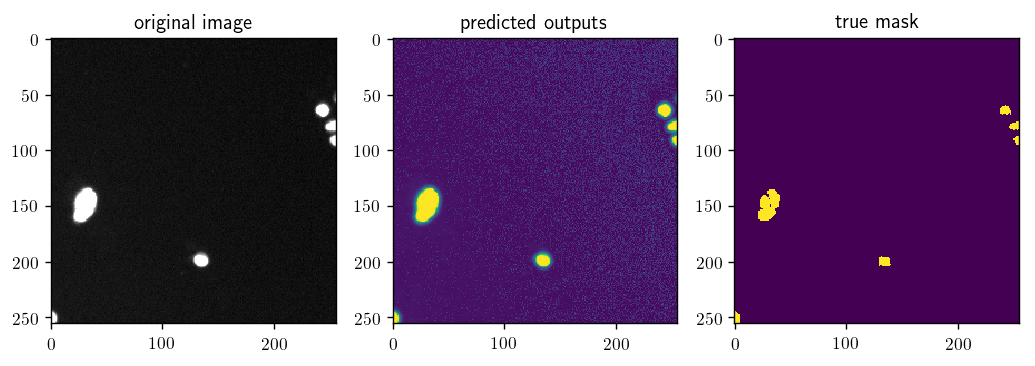

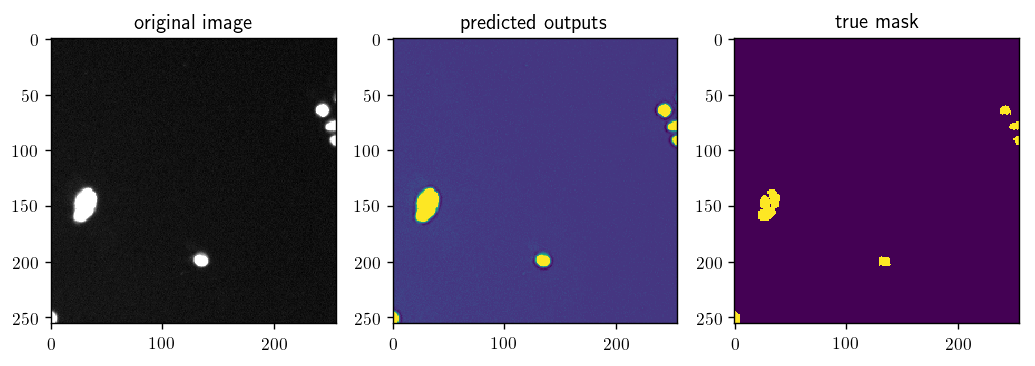

In [511]:
num = 5
plot_prediction(sgd_regressor, x_val_transformed[num], y_val[num])
plot_prediction(pa_regressor, x_val_transformed[num], y_val[num])

# UNet

In [512]:
x_dev_extended = np.zeros((len(x_dev), 256, 256, 2))
x_dev_extended[:, :, :, 0] = sgd_regressor.predict_images(x_train_transformed)
x_dev_extended[:, :, :, 1] = pa_regressor.predict_images(x_train_transformed)

In [513]:
x_val_extended = np.zeros((len(x_val), 256, 256, 2))
x_val_extended[:, :, :, 0] = sgd_regressor.predict_images(x_val_transformed)
x_val_extended[:, :, :, 1] = pa_regressor.predict_images(x_val_transformed)

In [605]:
from deton8.preprocess import preprocess
x_val_extended_new = preprocess(x_val)

100%|██████████| 134/134 [00:05<00:00, 26.31pair/s]


In [861]:
x_train_extended = preprocess(x_train)
x_val_extended = preprocess(x_val)

100%|██████████| 134/134 [00:05<00:00, 25.51pair/s]


In [514]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [515]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            horizontal_flip=True, 
            vertical_flip=True,
            zoom_range=0.2,
            shear_range=0.2).flow(x_train, x_train, batch_size, seed=42)
    mask_generator = ImageDataGenerator(
            horizontal_flip=True, 
            vertical_flip=True,
            zoom_range=0.2,
            shear_range=0.2).flow(y_train, y_train, batch_size, seed=42)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

In [867]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f) )

def mean_iou(y_true, y_pred):
    score, up_opt = tf.metrics.mean_iou(y_true, y_pred, 2)
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score

input_layer = Input(shape=x_train_extended.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model_regress = Model(input_layer, output_layer)

In [868]:
def dice_coef_loss(y_true, y_pred):
    return -1*dice_coef(y_true, y_pred) #+ K.max(y_pred,0)-y_pred * y_true + K.log(1+K.exp((-1)*K.abs(y_pred)))

model_regress.compile(optimizer=Adam(.01), loss=dice_coef_loss, metrics=[dice_coef, mean_iou, 'acc'])

In [859]:
model_regress.load_weights("../weights/unet_weights.h5")

In [869]:
hist = model_regress.fit_generator(my_generator(x_train_extended, np.expand_dims(y_dev, axis = 3), 8),
                           steps_per_epoch = 25,
                           validation_data = (x_val_extended, np.expand_dims(y_val, axis = 3)),
                           epochs=500, verbose=True)

Epoch 1/500


/Users/williamlevine/anaconda2/envs/py36/lib/python3.6/site-packages/keras/preprocessing/image.py:935: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (536, 256, 256, 10) (10 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


25/25 [==============================] - 94s 4s/step - loss: -0.6878 - dice_coef: 0.6878 - mean_iou: 0.5026 - acc: 0.8811 - val_loss: -0.7973 - val_dice_coef: 0.7973 - val_mean_iou: 0.6820 - val_acc: 0.9291
Epoch 2/500
25/25 [==============================] - 89s 4s/step - loss: -0.8149 - dice_coef: 0.8149 - mean_iou: 0.7291 - acc: 0.9175 - val_loss: -0.8472 - val_dice_coef: 0.8472 - val_mean_iou: 0.7391 - val_acc: 0.9470
Epoch 3/500
25/25 [==============================] - 70s 3s/step - loss: -0.8225 - dice_coef: 0.8225 - mean_iou: 0.7415 - acc: 0.9131 - val_loss: -0.8488 - val_dice_coef: 0.8488 - val_mean_iou: 0.7477 - val_acc: 0.9452
Epoch 4/500
25/25 [==============================] - 79s 3s/step - loss: -0.8632 - dice_coef: 0.8632 - mean_iou: 0.7529 - acc: 0.9243 - val_loss: -0.8659 - val_dice_coef: 0.8659 - val_mean_iou: 0.7594 - val_acc: 0.9495
Epoch 5/500
25/25 [==============================] - 88s 4s/step - loss: -0.7887 - dice_coef: 0.7887 - mean_iou: 0.7619 - acc: 0.9099 - 

KeyboardInterrupt: 

As we can see, our model seems to perform well across data modalities, one of our initial fears.  While the high degree of noise in the image above resulted in large noise in the predicted image, we're confident in our post-processing and segmentation code to only select the areas of interest.  Let's take a look at our **pixel F1** scores using naive global thresholds to binarize our image.  Note that this has nothing to do with the competition metric, which is much more involved.

### Post-Processing and Individual Nucleus Segmentation

Rather than just predicting which pixels belong to nuclei, this competition requires us to submit individual masks for each nuclei we identify in the images.  As a result, we have to perform post-processing to binarize the images effectively and then individually segment the binary image to determine the location of our nuclei.

Our post-processing is the combination of Otsu's Binarization with NMS mentioned above.  After this, we perform the following steps to segment our nuclei:

* perform a euclidean distance transform
* perform NMS on the distance transform to identify nuclei centers
* perform a watershed segmentation on the distance transform, using the NMS as markers of the watershed basins

Observe some results of our segmentation below:

In [575]:
from scipy.ndimage.morphology import binary_fill_holes

from deton8.computer_vision import postprocess
from deton8.visualization import plot_segmentation
from deton8.utils import f1
from deton8.components import watershed_cc

In [738]:
predictions = model_regress.predict(x_val_extended)

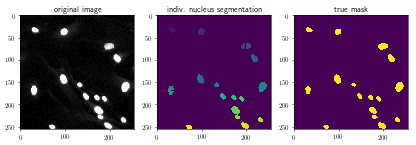

In [739]:
num = 130
plot_segmentation(x_val_transformed[num], binary_fill_holes(postprocess(model_regress.predict(np.expand_dims(x_val_extended[num], axis=0)), min_area=10) > 0), y_val[num])

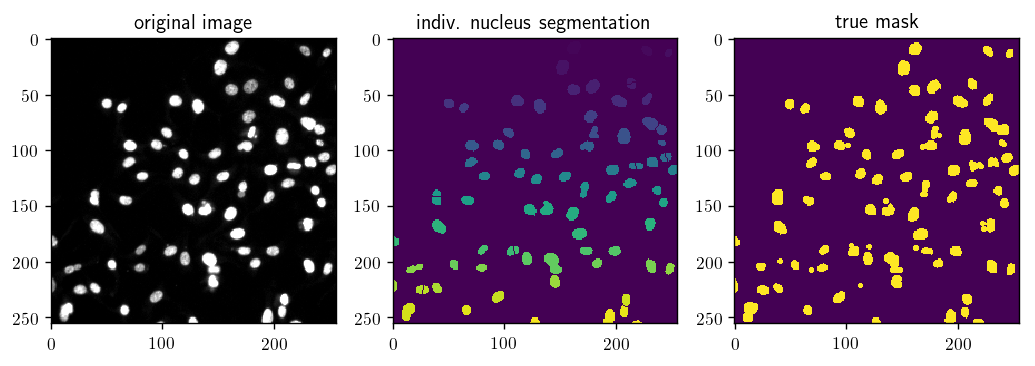

In [583]:
num = 0
plot_segmentation(x_val_transformed[num], postprocess(model_regress.predict(np.expand_dims(x_val_extended[num], axis=0)), min_area=10) > 0, y_val[num])

In [ ]:
num = 16
plot_segmentation(x_val[num], binary_fill_holes(NMCS(sgd_regressor.predict(x_val[num].reshape((256*256, 9))).reshape((256, 256)), percent=.995, min_area=15) > 0), y_val[num])

One can see that our individual segmentation performs particularly well for sparser data, however can get someone confused for denser data.  In addition to this, we find that occasionally run into oversegmentation issues, in which we actually split a sincle nucleus into two.  This happens when the nucleus has two "bulges" like the peanut shaped one in the image above.  The NMS that we are using isn't very complex, and can definitely be improved.  We're simply using `skimage.feature.peak_local_max` to determine the nuclei centroids, but we might need to do some fancier stuff to effectively segment.  This will be a focus of ours moving forward.

### about the whole submission thing

We still haven't been able to get a working submission submitted.  We have a pipeline that we believe should work, but have run into errors on Kaggle.  Our latest error explained that we had allocated the same pixel to different masks :(  Either way, since we have our individual nucleus segmentation set up, we should be able to submit relatively easily once we find and work out the kinks in the run-length encoding of our data.

## Moving Forward

We have a few areas that we want to focus on, as well as the meat of our pipeline to go.  

The biggest thing we want to do moving forward is to use a Deep Convolutional Neural Network to perform our image regression using our hand-designed features **stacked with the outputs of `SGDRegressor` and `PassiveAggressiveRegressor`** as inputs.  Since we are already acheiving .8 to .9 F1 scores on the validation set with our simple pixel based regressors, we believe we'll be able to achieve this or better with the CNN approach.  We plan on trying out a U-Net, as common with most kernels on Kaggle, as well as other forms of segmentation networks such as  a [Mask-RCNN](https://github.com/matterport/Mask_RCNN) or a [MSD-Net](https://slidecam-camera.lbl.gov/static/asset/PNAS.pdf).

In addition to this, we plan to focus most of our efforts on Data Augmentation.  In addition to standard image augmentation techniques, such as those enumerated in the [`imgaug` package](https://github.com/aleju/imgaug), we plan on developing our own image augmentation method.  This problem is unique in that we have individual masks over the areas of interest in our images.  So, we are able to actually *extract* the information of interest in our images, rotate, flip, etc... **individual nuclei** and plop them down on a new background, in a new image.  We are planning on generating lots of new training data, in order to help our Deep CNN generalize as much as possible.

Of course, one of the biggest effects on our final score will be how effective our post-processing and individual nucleus segmentation is, so we'll have to look into and invest more time in that.  It's possible we might be able to use a network to perform this task for us, but we'll have to see.

So far this problem has been very fun and exciting, and we're looking forward to continuing to develop and flesh out our solution.

In [2]:
from deton8.pipeline import pipeline
x_test_output, test_metadata = pipeline('../data/testing/')

/Users/williamlevine/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
100%|██████████| 65/65 [00:02<00:00, 26.29pair/s]


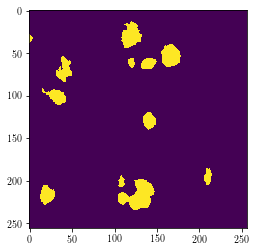

In [5]:
num = 10
plt.imshow((x_test_output[num]) > 0)
plt.show()

In [7]:
from deton8.submission import RLEncoder
from deton8.components import NucleiSegmenter


segmenter = NucleiSegmenter()
components = segmenter.fit_transform(x_test_output)

In [10]:
encoder = RLEncoder()
submission_df = encoder.fit_transform(test_metadata, np.array(components))

In [11]:
submission_df.to_csv("../submissions/20180318-01.csv", index=False)

In [17]:
from deton8.submission import rle_encode
for im in 
print(rle_encode(components[0] == 0))

[    1   150   169 ...   148 65520    17]
